## Make a feature-centric eddy composite

In [1]:
import eddy_tracks
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.interpolate
import metpy.calc as mpcalc
import math

### Define some functions

In [2]:
def calc_distance(eddy,xlen,ylen):
    
    distances= np.empty([ylen, xlen])
    
    #Haversine formula, assumes Earth is a sphere
    R = 6373.0 #radius of earth (km)

    lat1 = selected_eddies.y.iloc[eddy]
    lon1 = selected_eddies.x.iloc[eddy]

    lat2 = ds.TLAT
    lon2 = ds.TLONG

    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)

    a = (np.sin(dlat / 2) * np.sin(dlat / 2) +
         np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) *
         np.sin(dlon / 2) * np.sin(dlon / 2))

    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distances = R * c
    return distances

In [3]:
def put_coords(databox):

        #first do lons
        start = -1*int(len(databox.lon)/2)
        if len(databox.lon)%2 == 0.:
            end=int(len(databox.lon)/2)
        else:
            end=int(len(databox.lon)/2 + 1)

        databox['lon']=np.arange(start,end,1)

        #now do lats
        start = -1*int(len(databox.lat)/2)

        if len(databox.lat)%2 == 0.:
            end=int(len(databox.lat)/2)
        else:
            end=int(len(databox.lat)/2 + 1)

        databox['lat']=np.arange(start,end,1) # databox = databox.assign_coords({'lat':np.arange(start,end,1)})

        return databox

In [4]:
def composite_an_eddy(selected_eddies, ds, var, n_reps, threshold_r):

    xlen=len(ds.nlon)
    ylen=len(ds.nlat)
    elen=len(selected_eddies)
    
    #initialize sum
    sum_databoxes = 0
    count_eddies = 0

    for eddy in np.arange(0,elen,1):
        #print("starting eddy ", eddy)

        distance = calc_distance(eddy,xlen,ylen)

        #normalize distance to eddy radius
        distance_normrad = distance / selected_eddies.radius_km.iloc[eddy]

        #extract just these values
        sorted_distances = np.sort(distance_normrad, axis=None)
        sorted_distances = sorted_distances[sorted_distances < threshold_r]
        limit_index=len(sorted_distances)

        #get the x,y indices of the qualifying gridcells
        indices = np.unravel_index(np.argsort(distance_normrad.data, axis=None), distance_normrad.shape)

        #make a subset based on the limit index for qualifying distances
        indices_subset = (indices[0][:limit_index],indices[1][:limit_index])

        #get the four indices for getting out hi res data in the box
        x_min, x_max=np.percentile(indices_subset[0], [0,100])
        y_min, y_max=np.percentile(indices_subset[1], [0,100])
        x_min = int(x_min)
        x_max = int(x_max)
        y_min = int(y_min)
        y_max = int(y_max)

        #extract data for the variable with these indices
        databox = var[x_min:x_max,y_min:y_max] # databox = var.isel(lon=slice(x_min,x_max+1), lat=slice(y_min,y_max+1))

        if np.isnan(databox).any() != True:

            count_eddies = count_eddies + 1

            #make databox an xr DataArray
            databox = xr.DataArray(databox,dims=('lat','lon'))

            databox_smooth = mpcalc.smooth_n_point(databox, 9, n_reps)
            databox_smooth = xr.DataArray(databox_smooth,dims=('lat','lon'))
            databox_smooth.attrs = databox.attrs

            #make it anomalies
            databox = databox - databox_smooth

            #put data in the coordinates so that the eddies can be overlaid with their centers aligned
            databox = put_coords(databox)

            #now make a running sum
            sum_databoxes = sum_databoxes + databox     

        else:
            print('skipping eddy number', eddy)

    #finally, out of the loop, divide by the eddy number so that we have mean
    composite = sum_databoxes / count_eddies
    
    return composite

### Step 1: get the tracks and set desired eddy characteristics

In [5]:
pth = '/glade/p/cgd/oce/people/mclong/hi-res-eco/data/analysis/tracks_20161128'
file_in = f'{pth}/0_pt_1_CESM_tracks.mat'
tracks = pd.DataFrame(eddy_tracks.track_mat2py(file_in))

In [6]:
tracks

,x,y,amp,area,u,age,Ls,id,cyc,year,mon,day
0,242.258195,40.498931,2.994491,10809.049919,NaN,10.0,58.656862,1,1,1,1,5
1,242.600100,-69.344310,0.125429,1307.723710,NaN,10.0,20.402485,2,1,1,1,5
2,242.700100,-64.131685,3.458723,6708.039396,5.631560,10.0,46.208606,3,1,1,1,5
3,245.400100,-61.955224,13.669557,10985.213312,26.323848,10.0,59.132918,4,1,1,1,5
4,245.600100,-67.146695,0.551876,1666.310001,NaN,10.0,23.030479,5,1,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1599345,258.500100,-63.513617,6.218261,9476.326775,11.992946,125.0,54.921840,230803,-1,5,12,31
1599346,258.600100,-55.425356,2.878914,6293.522627,8.810720,35.0,44.758133,236814,-1,5,12,31
1599347,258.600100,-49.654134,0.655865,8606.090785,NaN,55.0,52.339314,235516,-1,5,12,31
1599348,258.800100,-21.714382,0.378134,8417.142072,NaN,20.0,51.761564,237872,-1,5,12,31


#### SET VARIABLES HERE

In [7]:
n_reps = 20      # number of repetitions for 9 pt smoother of databox
threshold_r=4    #radius normalized distance threshold for including in composite
variables = ['Fe','spChl','diatChl','PO4','TEMP','diat_N_lim','SSH','NO3',] ############### set here!!

age_min=30     #eddy age in days
amp_min=1      #eddy amplitude in cm
year=5         
month=12       
day=31         
lat_max=-30
lat_min=-40
lon_max=360
lon_min=0
eddy_type=-1    #anticyclonic = 1, cyclonic=-1

In [8]:
#sort by age, amplitude, size, lon/lat range, and eddy type
selected_eddies = tracks[(tracks.age >= age_min) & 
                         (tracks.amp >= amp_min) & 
                         (tracks.year == year) & 
                         (tracks.mon == month) &
                         (tracks.day == day) & #comment to get all the availabe days in this month
                         (tracks.y < lat_max) &
                         (tracks.y > lat_min) &
                         (tracks.x < lon_max) &
                         (tracks.x > lon_min) &
                         (tracks.cyc == eddy_type)]

In [9]:
#rename column
selected_eddies = selected_eddies.rename(columns={"Ls": "radius_km"})
selected_eddies

,x,y,amp,area,u,age,radius_km,id,cyc,year,mon,day
1597361,244.2001,-36.345233,1.313309,5619.613461,NaN,100.0,42.293954,232132,-1,5,12,31
1597363,244.9001,-30.934940,1.124256,15913.820013,NaN,30.0,71.172510,236818,-1,5,12,31
1597378,248.4001,-37.226641,2.879890,15162.431559,7.584083,105.0,69.471950,231806,-1,5,12,31
1597382,248.9001,-38.881010,1.513546,5303.359267,NaN,30.0,41.086636,236820,-1,5,12,31
1597389,250.8001,-33.724199,3.303866,18409.638567,9.089564,90.0,76.550441,232809,-1,5,12,31
...,...,...,...,...,...,...,...,...,...,...,...,...
1599298,248.9001,-38.881010,1.455372,5006.897314,NaN,30.0,39.921735,237144,-1,5,12,31
1599304,250.8001,-33.724199,3.370460,19170.032484,8.885791,90.0,78.115369,233124,-1,5,12,31
1599335,256.0001,-30.159517,1.178888,21004.733099,NaN,50.0,81.768051,235838,-1,5,12,31
1599337,256.7001,-31.789209,1.265494,11168.512408,NaN,60.0,59.624223,235181,-1,5,12,31


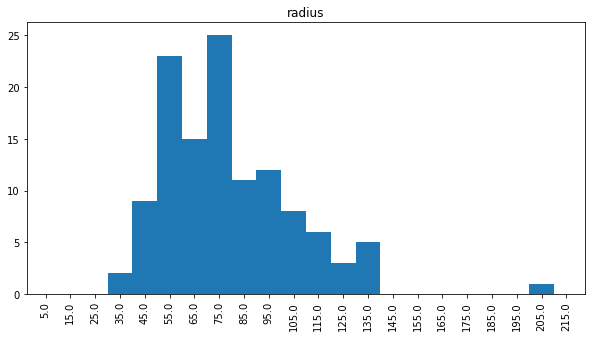

In [10]:
### visualize the distribution of eddy radii
hist_fields = {'radius_km': np.arange(0, 230, 10)}

df_hist = pd.DataFrame()
for fld, bins in hist_fields.items():
    midpoints = (bins[1:] + bins[:-1])/2.
    df_hist[fld] = pd.cut(selected_eddies[fld], bins, labels=midpoints)
    plt.figure(figsize=(10,5))
    df_hist[fld].value_counts(sort=False).plot.bar(width=1.)
    plt.title("radius")

In [11]:
#let's just get the eddies with a radius between 45 and 55 km:
selected_eddies = selected_eddies[(selected_eddies.radius_km >= 55)]
selected_eddies = selected_eddies[(selected_eddies.radius_km < 65)]
len(selected_eddies)

22

### Step 2: get the high-res gridded data 

In [12]:
case = 'g.e11.G.T62_t12.eco.006'
y4 = "{:04d}".format(year)
m2 = "{:02d}".format(month)
d2 = "{:02d}".format(day)

file = f'/glade/scratch/mclong/hi-res-eco/{case}/ocn/hist/{case}.pop.h.{y4}-{m2}-{d2}.nc'
ds = xr.open_dataset(file, decode_times=False, decode_coords=False)
coords = {'x':'TLONG','y':'TLAT'}
keep_vars = variables + list(coords.values())+['dz','KMT']
ds = ds.drop([v for v in ds.variables if v not in keep_vars]).squeeze()

### Step 3: cycle through variables and make a composite for each one

In [13]:
%%time
ds_list = []

composite_ds = xr.Dataset()

for varname in variables:
    
    print(varname)
    var = ds[varname]
    var.attrs=([]) #getting rid of attributes because it messes up the metpy smoother
    
    if len(var.dims)>2: #select surface
        if var.dims[0]=='z_t_150m':
            var = var.isel(z_t_150m=0).squeeze()
        if var.dims[0]=='z_t':
            var = var.isel(z_t=0).squeeze()
    
    composite = composite_an_eddy(selected_eddies, ds, var, n_reps, threshold_r)
    
    composite_ds[varname] = composite

Fe
skipping eddy number 13
spChl
skipping eddy number 13
diatChl
skipping eddy number 13
PO4
skipping eddy number 13
TEMP
skipping eddy number 13
diat_N_lim
skipping eddy number 13
SSH
skipping eddy number 13
NO3
skipping eddy number 13
CPU times: user 8min 34s, sys: 1min 23s, total: 9min 58s
Wall time: 10min 1s


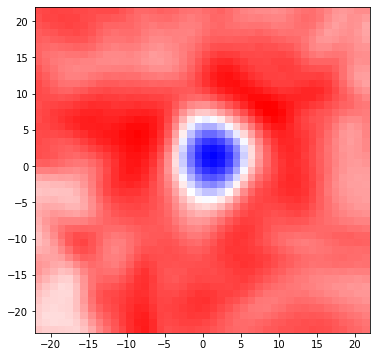

In [14]:
fig = plt.figure(figsize=(6,6))

ax = fig.add_subplot(1,1,1)
pc=ax.pcolormesh(composite.lon, composite.lat, composite_ds['SSH'], cmap='bwr')

In [15]:
num_comp=len(variables)
fig_width = num_comp * 2
fig_height = (num_comp * 3) - 3
rows = math.ceil(num_comp/2)
cols = 2

In [16]:
fig_width

16

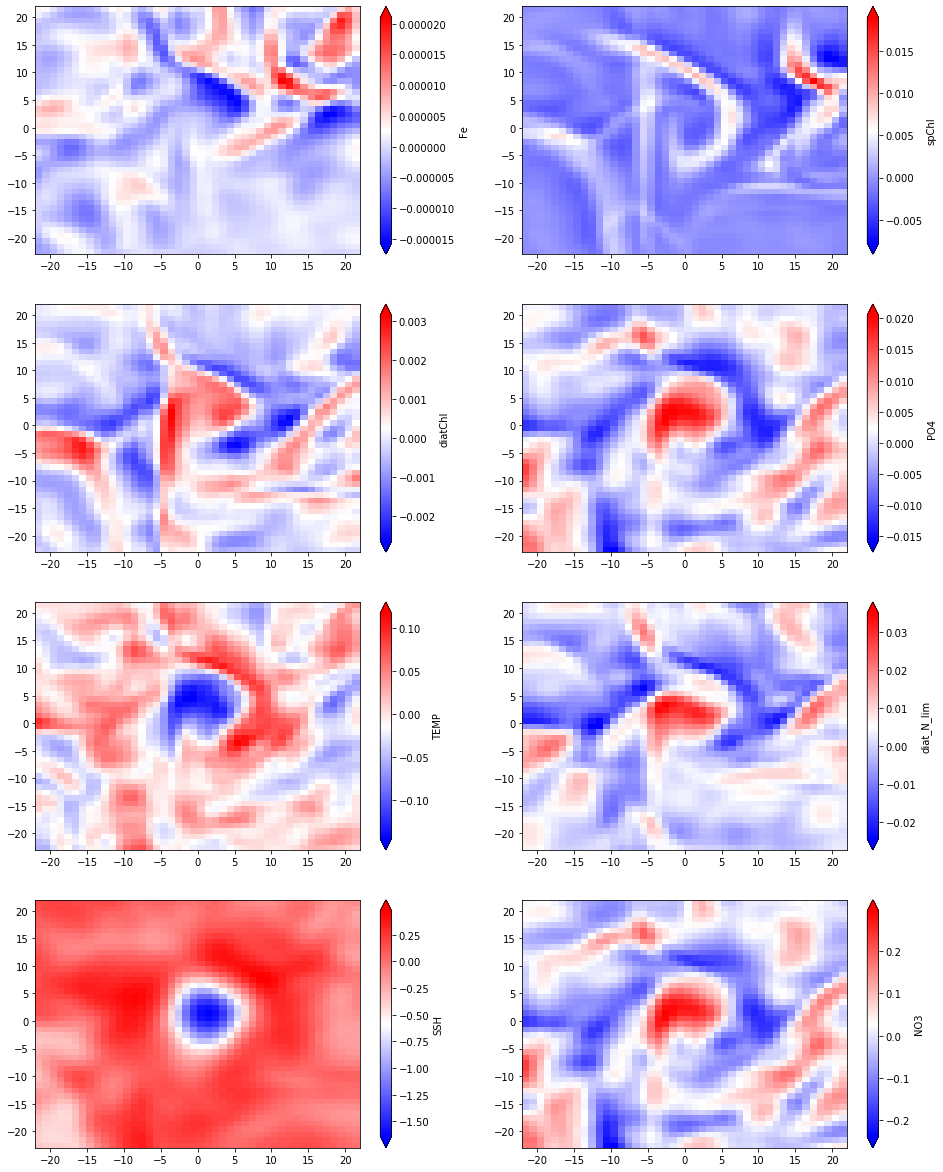

In [17]:
fig = plt.figure(figsize=(fig_width,fig_height))
count = 1
for varname in variables:
    ax = fig.add_subplot(rows,cols,count)
    pc=ax.pcolormesh(composite.lon, composite.lat, composite_ds[varname], cmap='bwr')
    cbar = fig.colorbar(pc, label=varname,extend='both')
    count = count + 1